<center style="font-size: 1cm"> Класификация на текст</center>


 Проблема, който ще разгледам се състой в това - за дадено CV(curriculum vitae) трябва да се предвиди класът към който то принадлежи - HR, Art ... като класовете са повече от 2, т.е multiclass и   съответното cv може да се  класифицира точно в един клас. Ще бъдат разгледани алгоритми за класификация, като Logistic Regression, SVM, како и ансамблови методи - bagging, boosting.

In [2]:
import pandas as pd
import numpy as np
import re
import string
import codecs
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from nltk import pos_tag
from nltk.corpus import wordnet 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
import pandas as pd
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

import os
%matplotlib inline

In [3]:

def load_grids():
    path = "./grids/Last/"
    grids = {}
    filenames = os.listdir(path)
    for filename in filenames:
        print(filename)
        grid_name = filename.split(".")[0]
        clf_name, type_ = grid_name.split("_")
        if clf_name not in grids:
            grids[clf_name] = {}
        grids[clf_name][type_] = joblib.load("{}{}".format(path,filename))
    return grids

In [4]:
clfs_defaults = {
    "LogisticRegression": LogisticRegression(),
    "LinearSVC": LinearSVC(),
    "SVC": SVC(),
    "RandomForest": RandomForestClassifier(),
    "MultinomialNB": MultinomialNB(),
    "Xgboost": XGBClassifier()
}
# classifiers_names = list(clfs_default.keys())

In [5]:
def clf_default_fit(clfs_default):
    # fit all classifiers from dict
    fitted = {}
    
    for clf_name, clf in clfs_default.items():
        pipe = Pipeline([
            ("vect", CountVectorizer()),
            ("clf", clf)
        ])
        pipe.fit(X_train, y_train)
        predicted = pipe.predict(X_test)

        fitted[clf_name] =  accuracy_score(y_test, predicted)

    return fitted

In [6]:
def select_best_clf_defaults(grids):
    clfs = {}
    
    for clf, grid in grids.items():
        if len(grid) == 2:
            g1 = grid["word"]
            g2 = grid["char"]
            clfs[clf] = g1 if g1.best_score_ > g2.best_score_ else g2
        else:
            clfs[clf] = list(grid.values())[0]
   
    return clfs

In [7]:
def process_clf_tuned_params(params_grid):
    #return classifier params from pipeline grid 
    params = params_grid.items()
    return {k.split("__")[1]: v for k, v in params if k.startswith("clf")}

In [8]:
def extract_params(clf_tuned_params, clf_orig_params):
    extracted_params = {}
#     processed_tuned_params = process_clf_tuned_params(clf_tuned_params)
    for k, v in clf_orig_params.items():
        if k in clf_tuned_params:
            extracted_params[k] = v
    return extracted_params

In [9]:
def init_table():
    table = {}
    table["clf_name"] = []
    table["clf_default_score"] =  []
    table["clf_tuned_score"] =  []
    return table

In [10]:
def make_table(clfs_tuned, clfs_default):
    table = init_table()
    fitted_default = clf_default_fit(clfs_default)
    clfs_names = clfs_tuned.keys()
    for clf_name_ in clfs_names:
        clf_tuned_params = process_clf_tuned_params(clfs_tuned[clf_name_].best_params_)
        clf_default_params = extract_params(clf_tuned_params, clfs_default[clf_name_].get_params())
        tuned_score = accuracy_score(y_test, clfs_tuned[clf_name_].predict(X_test))
        table["clf_name"].append(clf_name_)
        table["clf_default_score"].append(fitted_default[clf_name_])
        table["clf_tuned_score"].append(tuned_score)
        print("Classifier {}\n\tParameters after hypertuning: {}\n\tDefault parameters: {}\n".format(clf_name_,
                                              print_params(clf_tuned_params),
                                              print_params(clf_default_params)))
        
    return pd.DataFrame(table)

In [77]:
def print_params(d):
    return ", ".join(["{}: {}".format(k, v) for k, v in d.items()])

In [2]:
stop_words = stopwords.words("english")

In [3]:
punctuation = string.punctuation

In [5]:
def differences(processed, lemmatized):
    diffs = []
    text = processed.split()
    lemmatized = lemmatized.split()
    for idx in range(len(text)):
        if text[idx] != lemmatized[idx]:
            diffs.append((text[idx] ,lemmatized[idx]))
            
    return diffs

In [6]:
def get_wordnet_pos(treebank_tag):
    treebank_tag = treebank_tag[0][1]
    
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("N"):
        return wordnet.NOUN
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [7]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = " ".join([lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag([word]))) for word in text])
    return text
lemmatize_text = np.vectorize(lemmatize_text)

In [46]:
def print_vocab(vectorizer):
    print(vectorizer.__class__.__name__)
    d = list(zip(*vectorizer.vocabulary_.items()))
#     return d[0]
    df = pd.DataFrame({"word": d[0], "occurrences": d[1]})
    return df.sort_values(by='occurrences', ascending=False)
    

In [16]:
def make_vect_params(params_dict, params_vect_tfidt=None):
    #Construct parameter grids for vectorizers
    params_word = {**params_dict["params_vect"], **params_dict["params_vect_word"]}
    params_char = {**params_dict["params_vect"], **params_dict["params_vect_char"]}
    
    if params_vect_tfidt != None:
        params_word = {**params_word, **params_dict["params_vect_tfidt"]}
        params_char = {**params_char, **params_dict["params_vect_tfidt"]}
    
    return params_word,params_char


In [18]:
def combine_param_grids(params_vect, params_clf, vect=None):
    params_word, params_char = make_vect_params(params_dict, vect)
    
    l = []
    for name, clf_grid in params_clf.items():
        params_clf_word = {**clf_grid, **params_word}
        params_clf_char = {**clf_grid, **params_char}
        l.append((name, params_clf_word,params_clf_char))
    return l

In [30]:
def train(clf_name):
    grids[clf_name] = {}
#     random_grid_search()
    for k, v in pipelines[clf_name].items():
        print("Hyperparameters tuning for {} on {} basis\n".format(clf_name, k))
        gs = random_grid_search(*v)
        grids[clf_name][k] = gs
        joblib.dump(gs, "./grids/Last/{}_{}.pkl".format(clf_name, k), compress=1) 

In [15]:
def random_grid_search(pipeline, params, cv=3, n_iter=20):
  
  rgs = RandomizedSearchCV(pipeline, param_distributions=params, cv=cv, n_jobs=4, n_iter=n_iter, verbose=1, random_state=42)
  rgs.fit(X_train, y_train)
  
  print("\n",rgs.best_estimator_.steps[1][1].__class__.__name__)
  print("Best parameters\n")
  print(rgs.best_params_,"\n")
  print("Best score {}\n".format(rgs.best_score_))
  return rgs

In [17]:
def make_pipeline(clf, vect=None):
    vectorizer = TfidfVectorizer if vect else CountVectorizer
    return Pipeline([
        ("vect", vectorizer(stop_words=stop_words)),
        ("clf", clf)
    ])

In [8]:
BAD_SYMBOLS = re.compile("[{}{}]".format(re.escape(punctuation),"\s\n'"))
REMOVE_BAD_SYMBOLS = re.compile('[^a-zA-Z #+_]')
REPLACE_UNKNOWN = re.compile("(\uf0b7|)")
REMOVE_DIGITS = re.compile("[0-9]+")
words_for_remove = ["name", "email", "e-mail", "address", "mobile", "phone", "surname"]
WORDS_REMOVE = re.compile("|".join(words_for_remove), re.IGNORECASE)
REMOVE_EMAIL = re.compile(r'([\w!#.$%,&*\s-]+@[\w.\s-]+)\b' ,flags=re.IGNORECASE)
REMOVE_URL = re.compile(r"\b((?:http://|www\.?)[\w/. #$@%&?=+\-]+[\w]/?)", re.IGNORECASE)

def clean_text(text):
    text = codecs.escape_decode(text[2:-1])[0].decode('utf8')
    
    text = WORDS_REMOVE.sub(' ', text)
    text = REMOVE_EMAIL.sub(' ', text)
    text = REMOVE_URL.sub(' ', text)
    text = BAD_SYMBOLS.sub(' ', text)
    text = REMOVE_DIGITS.sub(' ', text)

    return text
clean_text = np.vectorize(clean_text)

In [9]:
def check_symbles(text):
    # find symbols different from a-zA-Z
    non_asci = []
    chars = [chr(c) for c in range(ord('a'), ord('z') +1)]
    chars.extend([chr(c) for c in range(ord('A'), ord('Z') + 1)])
    chars.append(" ")
    for char in list(text):
        if char not in chars:
            non_asci.append(char)
    return list(non_asci)
check_symbles = np.vectorize(check_symbles)

In [9]:
data = pd.read_csv("dataset/resume_dataset.csv")

In [10]:
data.drop(columns=["ID"], inplace=True)

In [16]:
data.loc[:,'char_num'] = data.Resume.apply(lambda x: len(list(x)))

In [20]:
data.head(10)

,Category,Resume,char_num
0,HR,"b'John H. Smith, P.H.R.\n800-991-5187 | PO Box...",6681
1,HR,b'Name Surname\nAddress\nMobile No/Email\nPERS...,1859
2,HR,b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...,7672
3,HR,b'www.downloadmela.com\nSatheesh\nEMAIL ID:\nC...,9971
4,HR,"b""HUMAN RESOURCES DIRECTOR\n\xef\x82\xb7Expert...",6386
5,HR,"b'John H. Smith, P.H.R.\n800-991-5187 | PO Box...",6681
6,HR,b'Resume of Satheesh\n\nwww.downlo\nSatheesh\n...,8938
7,HR,"b""GM HR & ADMINISTRATION Resume Sample www.tim...",10143
8,HR,"b""www.uaehrzone.com\n\nRobert Wales\nDubai\nUn...",10945
9,HR,"b""Human Resources Coordinator Resume\nExample\...",2680


In [18]:
print("{} записа и {} класа".format(data.shape[0], len(data.Category.unique())))

1219 записа и 25 класа


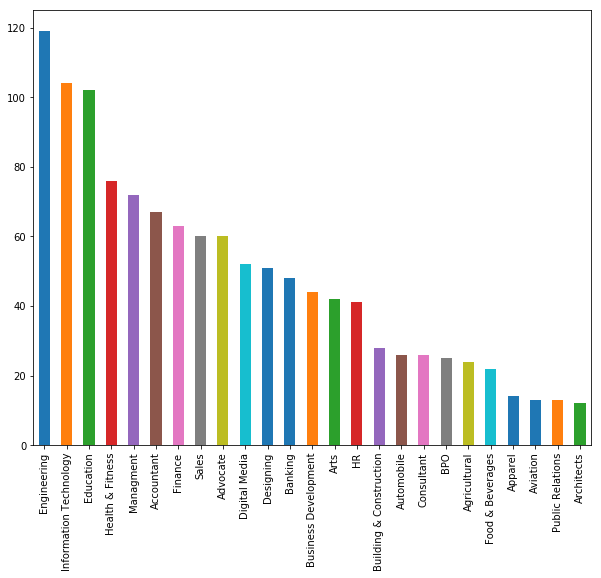

In [12]:
plt.figure(figsize=(10,8))
data.Category.value_counts().plot.bar()

Да видим дали има празни резюмета

In [19]:
data.loc[:,'char_num'] = data.Resume.apply(lambda x: len(list(x)))
data.sort_values(by='char_num').head(15)

,Category,Resume,char_num
487,Health & Fitness,b'',3
716,Digital Media,b'',3
132,Managment,b'',3
629,Sales,b'',3
720,Digital Media,b'',3
146,Managment,b'',3
752,Automobile,b'',3
826,Finance,b'',3
977,Engineering,b'',3
402,Advocate,b'',3


Махаме празните резюмета

In [20]:
data = data[data.Resume.apply(lambda x: len(list(x))) > 3]

In [21]:
data.sort_values(by='char_num').head(15)

,Category,Resume,char_num
310,Education,b'Resume for Sample Purposes Only\n\nby \xc3\x...,82
949,Engineering,b'Engineering Fresher Resume\n\n\x0c\xef\x82\x...,209
972,Engineering,b'N\n\name\n\nName\nAddress\nPhone :\nE-mail:\...,500
1171,Arts,b'Mitch Myers\nHeight:\nWeight:\nHair:\nEyes:\...,591
753,Automobile,b'\xef\x82\xb7 Salesperson\n\xef\x82\xb7 Aircr...,598
851,Finance,"b""Assistant Finance Director Resume\nWork Expe...",641
755,Automobile,b'Richard Bay\nFrontier Road\nGermany\nPhone: ...,768
768,Automobile,b'Dean Perry\nWork shire Road\nLondon\nPhone: ...,834
58,Designing,"b'Hannah Oyler\n21 Balsom St\nVentura, CA 9412...",852
1129,Banking,b'Cashier Resume Templates\n\nMonica Gill\nFro...,853


Сега ще премахнем препинателни знаци, телефони, имейли, линкови и числа

In [22]:
data.loc[:,"Cleaned"] = data.Resume.apply(clean_text)


Да видим дължината след почистването

In [23]:
data.loc[:, "char_num_cleaned"] = data.Cleaned.apply(lambda x: len(list(x)))

In [24]:
data.head()

,Category,Resume,char_num,Cleaned,char_num_cleaned
0,HR,"b'John H. Smith, P.H.R.\n800-991-5187 | PO Box...",6681,John H Smith P H R PO Box Calla...,5624
1,HR,b'Name Surname\nAddress\nMobile No/Email\nPERS...,1859,No PERSONAL PROFILE I am a self moti...,1655
2,HR,b'Anthony Brown\nHR Assistant\nAREAS OF EXPERT...,7672,Anthony Brown HR Assistant AREAS OF EXPERTISE ...,6553
3,HR,b'www.downloadmela.com\nSatheesh\nEMAIL ID:\nC...,9971,Satheesh ID Career Objective To pursue a ...,8683
4,HR,"b""HUMAN RESOURCES DIRECTOR\n\xef\x82\xb7Expert...",6386,HUMAN RESOURCES DIRECTOR Expert in organizati...,5975


In [25]:
resume, cleaned_resume = data.loc[data.index == 4, ["Resume", "Cleaned"]].values[0]

In [26]:
print(resume[:1000])

b"HUMAN RESOURCES DIRECTOR\n\xef\x82\xb7Expert in organizational effectiveness.\n\xef\x82\xb7Recognized consensus-builder among diverse groups.\n\xef\x82\xb7Innovative problem solver.\n\xef\x82\xb7Strategic partner.\n\xef\x82\xb7Effective executive coach.\n\xef\x82\xb7Facilitator of management/staff collaboration to achieve business goals.\n\xef\x82\xb7Watchdog against corporate legal liability and exposure.\nVALUE PROPOSITION\nBringing balance and simplicity to Human Resources processes, I create a competitive\nadvantage for the business that is reflected in the bottom line.\nProactive in anticipating problems and active in fixing things that break, I attract and retain a\nhighly skilled and motivated workforce by implementing innovative and cost-saving programs.\nLEADERSHIP\nEmployee Relations: Balance the company's best interests with the employees' needs to\nachieve business goals. Implement best management practices to maintain high morale in\nmultinational and multisite businesse

In [27]:
print(cleaned_resume[:1000])

HUMAN RESOURCES DIRECTOR Expert in organizational effectiveness  Recognized consensus builder among diverse groups  Innovative problem solver  Strategic partner  Effective executive coach  Facilitator of management staff collaboration to achieve business goals  Watchdog against corporate legal liability and exposure  VALUE PROPOSITION Bringing balance and simplicity to Human Resources processes  I create a competitive advantage for the business that is reflected in the bottom line  Proactive in anticipating problems and active in fixing things that break  I attract and retain a highly skilled and motivated workforce by implementing innovative and cost saving programs  LEADERSHIP Employee Relations  Balance the company s best interests with the employees  needs to achieve business goals  Implement best management practices to maintain high morale in multinational and multisite businesses  Staffing  Identify and define high quality candidates in a tight job market and reduce cost 

In [28]:
all_unknown = data.Cleaned.apply(check_symbles)

In [29]:
all_unknown = np.unique(np.concatenate(all_unknown.values))

In [30]:
print(all_unknown)

['\x01' '\x02' '\x03' '\x04' '\x05' '\x06' '\x07' '\x08' '\x0e' '\x0f'
 '\x10' '\x11' '\x12' '\x13' '\x14' '\x15' '\x16' '\x17' '\x18' '\x19'
 '\x1a' '\x1b' '\x80' '\x83' '\x89' '\x8a' '\x8f' '\x90' '\x93' '\x95'
 '\x97' '\x98' '\x99' '\x9c' '\x9d' '£' '¤' '§' '©' '«' '\xad' '®' '°' '²'
 '´' '·' '»' '½' '¾' '¿' 'Â' 'Ä' 'Ç' 'È' 'É' 'Í' '×' 'Ø' 'Ü' 'ß' 'à' 'á'
 'â' 'ä' 'æ' 'ç' 'è' 'é' 'ê' 'ë' 'í' 'î' 'ï' 'ñ' 'ò' 'ó' 'ô' 'ö' 'ú' 'û'
 'ü' 'Ă' 'ć' 'ē' 'ğ' 'ı' 'ń' 'ō' 'Ś' 'š' 'ű' 'Ÿ' 'ƒ' 'ɡ' '˘' '˜' '́' '̈'
 '̊' '̌' '̒' ';' 'Α' 'Μ' 'Ω' 'α' 'ـ' 'Ⴙ' '\u200b' '‐' '–' '—' '―' '‖' '‘'
 '’' '“' '”' '„' '‟' '•' '…' '\u202a' '\u202b' '\u202c' '‰' '€' '™' '←'
 '⇛' '−' '∗' '∙' '√' '∼' '≈' '⎯' '│' '■' '▪' '▬' '●' '◦' '☏' '♦' '✔' '✥'
 '❖' '⫹' '。' 'き' 'し' 'そ' 'て' 'と' 'の' 'ォ' 'ギ' 'ク' 'ッ' 'ド' 'ビ' 'フ' 'マ' 'ー'
 '䡲' '上' '中' '九' '人' '代' '伊' '俗' '傳' '出' '勉' '化' '卷' '原' '啟' '嘉' '四' '回'
 '図' '国' '國' '墨' '妍' '孙' '季' '学' '宗' '家' '局' '庭' '弘' '徽' '房' '政' '文' '新'
 '明' '星' '時' '术' '梅' '残' '毕' '河' '治' '清' '照' '版' '珍' '画

In [31]:
REMOVE_INVALID = re.compile("|".join(all_unknown))
data["Cleaned"] = data.Cleaned.str.replace(REMOVE_INVALID, " ")

Накрая да видим колко единични букви са останали в резюметата и да ги заменим с празно място, както и празните места с повече от един интервал ще бъдат заменени с едно празно място

In [32]:
data.Cleaned.apply(lambda x: len([w for w in x.split(" ") if len(w) == 1])).sort_values(ascending=False)[:20]

501     1107
287      970
965      695
489      509
506      412
893      374
512      352
347      337
900      337
34       296
729      287
515      280
713      271
189      265
491      257
742      256
1208     245
1078     236
914      232
992      232
Name: Cleaned, dtype: int64

In [33]:
data["Cleaned"] = data.Cleaned.str.replace(r"\b\w\b", ' ').values

In [30]:
cp = data.copy()

In [31]:
cp.loc[:, "Cleaned"] = cp.Cleaned.apply(lambda x: re.sub(r'\s+', " ", x))
cp.loc[:, "char_num_cleaned"] = cp.Cleaned.apply(lambda x: len(list(x)))

In [32]:
lesst_than_50 = cp[cp.char_num_cleaned  <50]

In [33]:
lesst_than_50

,Category,Resume,char_num,Cleaned,char_num_cleaned
797,Finance,b'\x01\x02\x03\x04\x05\x06\x05\x07\x06\x08\t\n...,18848,,1
949,Engineering,b'Engineering Fresher Resume\n\n\x0c\xef\x82\x...,209,Engineering Fresher Resume,27
1187,Arts,"b'! ""\n$\n\n""\n%\n\n#\n\n&\n\n!\n\'\n\'& ( )\n...",3807,IG,4


In [34]:
id_797, id_1187 = lesst_than_50.iloc[[0,2]].Resume.values

In [35]:
print(id_797)

b'\x01\x02\x03\x04\x05\x06\x05\x07\x06\x08\t\n\n\t\x04\x0b\x0c\r\x0e\x06\x01\x0f\x03\x06\n\x0c\x10\t\x04\x03\x11\x12\x0c\r\x0b\x06\x0f\x03\r\x03\x13\t\x0f\t\r\x11\x06\x14\x06\x0b\x04\x07\x06\n\x12\r\x03\r\x01\x12\x03\x02\x06\t\x15\t\x01\x16\x11\x12\x17\t\x06\x02\t\x03\x18\t\x04\x06\n\n\x01\x02\x03\x04\x05\x04\x06\x07\x08\t\x04\n\x0b\x0c\r\x0e\x04\x04\n\x0f\x10\x11\x12\x10\x12\x04\x13\x14\x15\x16\x17\x04\x18\x19\x04\x1a\x1b\x1b\x01\x02\x04\n\x1c\x1d\t\x11\x07\x1e\x04\x1f\x1b\x1b\x0e \x02\x0e\x1a\x02\x1f!\x04\n"\x1e\x04#\x0b\x10\x08$$%\x07&&\x07\x08\x12\t\x11\'()\x10\x14\x0b\x0e#\t)\x04\n\n\x01\n\n\t\x15\t\x01\x16\x11\x12\x17\t\x06\x10\x04\x0c\n\x12\x02\t\x06\n\x01\n\x01\x02\x03\x04\x02\x05\x06\x07\x08\t\n\x0b\x04\x0c\x0c\x07\x0c\x06\t\n\r\x07\x0c\x04\x0c\x08\x07\x04\x0b\t\x01\x02\x03\x04\x02\x05\x06\x0e\t\x0f\t\n\x10\x11\x12\x06\x05\x02\x04\x03\x0e\t\x13\x14\x05\x03\x15\x07\x06\x16\x02\t\n\x17\x03\x18\x15\x15\x19\r\x11\x0c\x08\x02\x07\x18\x0c\x04\x0b\t\x1a\x05\x04\x1b\t\n\x1c\x05\x04\x1

In [36]:
print(id_1187)

b'! "\n$\n\n"\n%\n\n#\n\n&\n\n!\n\'\n\'& ( )\n\n$\n#\n\n!\n"!\n+\n\n!!\n"\n\n!\n\n$\n\n!*\n\n%\n#\n\n"\n) "\n!\n\n& !\n\n(\n\n!\n\n$\n\n!\n\n&\'\n\n) $ *\n\n+$\n\n)\n\n!\n!\n\n!\n\n!\n\n* ,\n\n!\n\n,\n1\n\n-../\n+ 3\n\n2\n\n5 ,\n\n0\n\n6\n1\n\n+# ,\n\n4\n\n+\n\n2\n\n7 7\n\n8\n\n9\n\n- ,\n\n9\n+ 2\n\n9\n5\n5\n"\n@,\n-\n\n,\n,\n\n: ;\n\n2 A1\n+;\n\n8\n5 ,\n- ,\n- ,\n\n9\n\nB", B%\n+\n$\n! 1\n\n4\n&\n\n<\n\n1\n;\n\n,\n\n#\n\n! 1\n"\n\n1\n\n+\n"\n\n"\n+\n9\n\n;\n\n4\n\n(\n2\n\n;\n\n#\n\n\'\'\n++\n++\n++\n++\n#\n\n+\n\n7 7\n\n1\n\n$&\n+\n\n8\n\n1\n1\n1\n1\n\n2 <=\n\n?\n, #\n\n9\n\n) %\n\n+ =\n\n#\n\n+\n\n+\n\n# <\n$\n\n(\n\n2\n\n#\n; 0\n\n#\n\n$\n\n) -!\n!\n!\n!\n!\n\n!\n\n3>.\n2\n\n(\n\n#\n,\n\n+\n\n1\n\n&\n+ " 0 2\n&\n&\n;\n\nB7 7 ?\n%\n=\n!, 6\n\n3 $\n, 0\n, 0 +\n+\n, C\n$ 2! , 0\n=7 7 , 0\n! -. (\n7\n!\n\n4\n-..:\n\n"\n\n\x0c%\n\n+\n\n!\n\n6\n"\n\n,\n\n+\n6\n! 1\n\n!&\n\n, C\n#\n#\n\n$\n\n;\n\n+\n\n+\n\n. $ -\n\n,\n\n, #\n!\n\n++\n\n,\n,\n\n! 1\n1\n\n"\n\n1\n1\n\n%\n\n, #\n#\n0\n+\n\n!+

In [37]:
data = cp.drop([797 , 1187],axis=0)

In [38]:
data.sort_values(by="char_num_cleaned")

,Category,Resume,char_num,Cleaned,char_num_cleaned
949,Engineering,b'Engineering Fresher Resume\n\n\x0c\xef\x82\x...,209,Engineering Fresher Resume,27
310,Education,b'Resume for Sample Purposes Only\n\nby \xc3\x...,82,Resume for Sample Purposes Only by Resumes For...,55
972,Engineering,b'N\n\name\n\nName\nAddress\nPhone :\nE-mail:\...,500,ame Objectives To pursue challenging career i...,357
753,Automobile,b'\xef\x82\xb7 Salesperson\n\xef\x82\xb7 Aircr...,598,Salesperson Aircraft Mechanic Satellite TV In...,383
1171,Arts,b'Mitch Myers\nHeight:\nWeight:\nHair:\nEyes:\...,591,Mitch Myers Height Weight Hair Eyes lbs Brown ...,413
851,Finance,"b""Assistant Finance Director Resume\nWork Expe...",641,Assistant Finance Director Resume Work Experie...,434
755,Automobile,b'Richard Bay\nFrontier Road\nGermany\nPhone: ...,768,Richard Bay Frontier Road Germany Possess skil...,450
1129,Banking,b'Cashier Resume Templates\n\nMonica Gill\nFro...,853,Cashier Resume Templates Monica Gill Frost Roa...,533
768,Automobile,b'Dean Perry\nWork shire Road\nLondon\nPhone: ...,834,Dean Perry Work shire Road London Efficient wo...,538
601,BPO,b'Call Center Manager Resume Template\nGary Hi...,996,Call Center Manager Resume Template Gary Hicks...,620


In [41]:
data["Lemmatized"] = data.Cleaned.apply(lemmatize_text)

In [42]:
doc = data.iloc[0].Cleaned
lematized = data.iloc[0].Lemmatized

In [156]:
lemmas = differences(doc, lematized)

In [157]:
print("Number of lemmatized words {}".format(len(lemmas)))
lemmas

Number of lemmatized words 133


[('working', 'work'),
 ('professionals', 'professional'),
 ('based', 'base'),
 ('settings', 'setting'),
 ('analyzing', 'analyze'),
 ('alternatives', 'alternative'),
 ('identifying', 'identify'),
 ('choices', 'choice'),
 ('communicating', 'communicate'),
 ('packages', 'package'),
 ('executives', 'executive'),
 ('employees', 'employee'),
 ('contracting', 'contract'),
 ('services', 'service'),
 ('employees', 'employee'),
 ('benefits', 'benefit'),
 ('programs', 'program'),
 ('smaller', 'small'),
 ('clients', 'client'),
 ('services', 'service'),
 ('leveraging', 'leverage'),
 ('skills', 'skill'),
 ('members', 'member'),
 ('claims', 'claim'),
 ('smaller', 'small'),
 ('plans', 'plan'),
 ('projections', 'projection'),
 ('forecasts', 'forecast'),
 ('trends', 'trend'),
 ('meetings', 'meeting'),
 ('specialists', 'specialist'),
 ('analyzing', 'analyze'),
 ('changes', 'change'),
 ('developing', 'develop'),
 ('plans', 'plan'),
 ('decisions', 'decision'),
 ('deadlines', 'deadline'),
 ('changes', 'chan

Да разделим данните 90/10, като с 10% ще се провери колко добре генерализират моделите, а на 90-те ще се прави "hyperparameter tuning".

In [65]:
X_train, X_test, y_train, y_test = train_test_split(data.Lemmatized, data.Category, test_size=0.10, random_state=42)

Да разгледаме baseline модел, който предсказва най-често срещания клас, който ще служи за отправна точка.

In [29]:

pipeline_dummy = Pipeline([
    ("vect", CountVectorizer()),
    ("clf", DummyClassifier(strategy="most_frequent"))
])
pipeline_dummy.fit(X_train, y_train)
dummy_predict = pipeline_dummy.predict(X_test)
print("Baseline модел: {}".format(accuracy_score(y_test, dummy_predict) * 100))

Baseline модел: 6.6115702479338845


In [63]:
data = pd.read_csv("resumes_final.csv")

In [64]:
data.drop(columns=['Unnamed: 0'], inplace=True)

Отдолу са дефинирани хиперпараметрите, който ще бъдат използвани в RandomizedGridSearch за да се намери оптимален модел. Първо са представени тези, които ще бъдат използвани при векторизацията на текста съответно но CountVectorizer/TfidfVectorizer в sklern

In [13]:
#  Dictionary containing parameter grids for vectorizers
params_dict = {
    "params_vect" : {
    "vect__max_df": [1.0, 0.9, 0.8, 0.7, 0.6, 0.5],
    "vect__min_df": [2, 3, 5, 10],
    "vect__lowercase": [True, False],
    },

    "params_vect_tfidt": {
        "vect__use_idf": [True, False],
        "vect__norm": ['l1', 'l2']
    },

    "params_vect_word": {
        "vect__ngram_range": [(1, 1), (1, 2), (1, 3)],
        "vect__analyzer": ["word"],
    },
    "params_vect_char": {
    "vect__ngram_range": [(3, 5)],
    "vect__analyzer": ["char"],
    }

}


и хиперпараметрите на класификаторите, който ще се оптимизират

In [14]:
clfs_dict = {
    "LogisticRegression": {
        "clf__penalty": ['l2'],
        "clf__max_iter": [4000],
        "clf__C": [0.001, 0.01, 0.1, 1, 10],
        "clf__solver": ["sag"],
        "clf__multi_class": ["ovr", "multinomial"],
        "clf__class_weight": [None, "balanced"]
    },
"LinearSVC": {
    "clf__penalty": ["l2", "l1"],
    "clf__dual": [False],
    "clf__C": [0.1, 1, 10, 100, 1000],
    "clf__class_weight": [None, "balanced"]
},
"SVC" :{
    "clf__kernel": ["rbf"],
    "clf__gamma": [0.001, 0.01, 0,1, 1],
    "clf__C": [0.1, 1, 10, 100, 1000],
    "clf__class_weight": [None, "balanced"]
},
"RandomForest": {
    "clf__criterion": ["gini", "entropy"],
    "clf__bootstrap": [True, False],
    "clf__max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "clf__max_features": ["sqrt", "auto"],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__min_samples_split": [2, 5, 10], 
    "clf__n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
},
"MultinomialNB": {
    "clf__alpha": [0.001, 0.01, 0.1, 0.5, 1, 5, 10]
},
"Xgboost": {
    "clf__max_depth": range(3, 10, 2),
    "clf__min_child_weight": range(1, 6, 2),
    "clf__gamma": [0.0, 0.1, 0.2, 0.3, 0.4],
    "clf__reg_alpha": [1e-5, 1e-2, 0.1, 1, 100],
    "clf__subsample": [0.6, 0.7, 0.8, 0.9],
    "clf__colsample_bytree": [0.6, 0.7, 0.8, 0.9]
}
}


До сега разгледаните модели с тунинговани хиперпараметри ще бъдат сравнени и с тяхните с по подразбиране

Тъй, като за всеки класификатор ще се направи сравнение на неговата точност със и без оптимизирани хиперпараметри следва да дефинираме класификаторите със техните параметри по подразбиране.

In [12]:
clfs = {
    "LogisticRegression": LogisticRegression(random_state=42),
    "LinearSVC": LinearSVC(random_state=42),
    "SVC": SVC(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "MultinomialNB": MultinomialNB(),
    "Xgboost": XGBClassifier(random_state=42)
}


In [13]:
grids = {}
pipelines = {}

При оптимизацията на хиперпараметрите са разгледани двата метода за векторизация на текста - bag of words и tf-idf. Като при тях са рагледани случайте, когато елементите в речника който се образува са букви или думи.   

In [29]:

for v in [None, "tfidf"]:
    for (name, word_params, char_params) in combine_param_grids(params_dict, clfs_dict, v):
        pipeline = make_pipeline(clfs[name], v)
        pipelines[name] = {}
        pipelines[name]["word"] = [pipeline, word_params]
        pipelines[name]["char"] = [pipeline, char_params]
                

Надолу ще видим пример за това какви feature-и се побучават след прилагаето та bag of words или tf-idf

Сега за всеки класификатор ще се изпълни RandomizedGridSearch. За него е показана комбинацията на хиперпараметрите за които той е оптимален(когато използа feature който са думи и когато са  букви). При крос валидацията, данните се делят на 3 приблизително равни части като на 2 от тях се тренира модела със съответната пройзволна комбинация от хирепараметри, а на останалата част се тества неговата точност на предсказване 

In [177]:
# train("LinearSVC")
# train("MultinomialNB")


Hyperparameters tuning for LinearSVC on word basis

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  5.2min finished



 LinearSVC
Best parameters

{'vect__use_idf': True, 'vect__norm': 'l2', 'vect__ngram_range': (1, 2), 'vect__min_df': 3, 'vect__max_df': 0.5, 'vect__lowercase': True, 'vect__analyzer': 'word', 'clf__penalty': 'l2', 'clf__dual': False, 'clf__class_weight': 'balanced', 'clf__C': 100} 

Best score 0.7072945521698984

Hyperparameters tuning for LinearSVC on char basis

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 30.6min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 47.9min finished



 LinearSVC
Best parameters

{'vect__use_idf': True, 'vect__norm': 'l1', 'vect__ngram_range': (3, 5), 'vect__min_df': 3, 'vect__max_df': 0.9, 'vect__lowercase': True, 'vect__analyzer': 'char', 'clf__penalty': 'l2', 'clf__dual': False, 'clf__class_weight': None, 'clf__C': 1000} 

Best score 0.7119113573407202

Hyperparameters tuning for MultinomialNB on word basis

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  1.6min finished



 MultinomialNB
Best parameters

{'vect__use_idf': True, 'vect__norm': 'l2', 'vect__ngram_range': (1, 1), 'vect__min_df': 10, 'vect__max_df': 0.9, 'vect__lowercase': True, 'vect__analyzer': 'word', 'clf__alpha': 0.1} 

Best score 0.6555863342566943

Hyperparameters tuning for MultinomialNB on char basis

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  8.2min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 11.1min finished



 MultinomialNB
Best parameters

{'vect__use_idf': True, 'vect__norm': 'l2', 'vect__ngram_range': (3, 5), 'vect__min_df': 10, 'vect__max_df': 0.5, 'vect__lowercase': True, 'vect__analyzer': 'char', 'clf__alpha': 0.01} 

Best score 0.6611265004616805



In [185]:
# train("SVC")

Hyperparameters tuning for SVC on word basis

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished



 SVC
Best parameters

{'vect__use_idf': True, 'vect__norm': 'l2', 'vect__ngram_range': (1, 1), 'vect__min_df': 10, 'vect__max_df': 1.0, 'vect__lowercase': True, 'vect__analyzer': 'word', 'clf__kernel': 'rbf', 'clf__gamma': 0.01, 'clf__class_weight': None, 'clf__C': 1000} 

Best score 0.6795937211449676

Hyperparameters tuning for SVC on char basis

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 23.7min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 33.2min finished



 SVC
Best parameters

{'vect__use_idf': True, 'vect__norm': 'l2', 'vect__ngram_range': (3, 5), 'vect__min_df': 10, 'vect__max_df': 1.0, 'vect__lowercase': True, 'vect__analyzer': 'char', 'clf__kernel': 'rbf', 'clf__gamma': 1, 'clf__class_weight': 'balanced', 'clf__C': 10} 

Best score 0.6565096952908587



In [188]:
# train("LogisticRegression")

Hyperparameters tuning for LogisticRegression on word basis

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reac

/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reac


 LogisticRegression
Best parameters

{'vect__use_idf': False, 'vect__norm': 'l2', 'vect__ngram_range': (1, 3), 'vect__min_df': 3, 'vect__max_df': 0.6, 'vect__lowercase': True, 'vect__analyzer': 'word', 'clf__solver': 'sag', 'clf__penalty': 'l2', 'clf__multi_class': 'ovr', 'clf__max_iter': 4000, 'clf__class_weight': 'balanced', 'clf__C': 10} 

Best score 0.7017543859649122

Hyperparameters tuning for LogisticRegression on char basis

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reac

KeyboardInterrupt: 

In [27]:
# train("RandomForest")

Hyperparameters tuning for RandomForest on word basis

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 13.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 15.8min finished



 RandomForestClassifier
Best parameters

{'vect__use_idf': False, 'vect__norm': 'l1', 'vect__ngram_range': (1, 3), 'vect__min_df': 5, 'vect__max_df': 0.6, 'vect__lowercase': False, 'vect__analyzer': 'word', 'clf__n_estimators': 1400, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': None, 'clf__criterion': 'gini', 'clf__bootstrap': False} 

Best score 0.6768236380424746

Hyperparameters tuning for RandomForest on char basis

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 43.7min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 73.5min finished



 RandomForestClassifier
Best parameters

{'vect__use_idf': True, 'vect__norm': 'l1', 'vect__ngram_range': (3, 5), 'vect__min_df': 3, 'vect__max_df': 0.5, 'vect__lowercase': False, 'vect__analyzer': 'char', 'clf__n_estimators': 1800, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': None, 'clf__criterion': 'gini', 'clf__bootstrap': False} 

Best score 0.6777469990766389



In [33]:
train("Xgboost")

Hyperparameters tuning for Xgboost on word basis

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig


 XGBClassifier
Best parameters

{'vect__use_idf': False, 'vect__norm': 'l2', 'vect__ngram_range': (1, 2), 'vect__min_df': 2, 'vect__max_df': 0.5, 'vect__lowercase': False, 'vect__analyzer': 'word', 'clf__subsample': 0.8, 'clf__reg_alpha': 1e-05, 'clf__min_child_weight': 1, 'clf__max_depth': 3, 'clf__gamma': 0.2, 'clf__colsample_bytree': 0.6} 

Best score 0.6648199445983379

Hyperparameters tuning for Xgboost on char basis

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig

/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambig


 XGBClassifier
Best parameters

{'vect__use_idf': True, 'vect__norm': 'l1', 'vect__ngram_range': (3, 5), 'vect__min_df': 3, 'vect__max_df': 0.5, 'vect__lowercase': True, 'vect__analyzer': 'char', 'clf__subsample': 0.7, 'clf__reg_alpha': 1, 'clf__min_child_weight': 3, 'clf__max_depth': 9, 'clf__gamma': 0.0, 'clf__colsample_bytree': 0.9} 

Best score 0.6694367497691598



In [14]:
grids = load_grids()

LogisticRegression_word.pkl
RandomForest_char.pkl
Xgboost_char.pkl
SVC_char.pkl
SVC_word.pkl
MultinomialNB_word.pkl
MultinomialNB_char.pkl
LinearSVC_char.pkl
LinearSVC_word.pkl
RandomForest_word.pkl
Xgboost_word.pkl


In [15]:
best_clf_default = select_best_clf_defaults(grids)


Да видим например за логистична регресия какво е построил TfidfVectorizer

In [47]:
print_vocab(best_clf_default["LogisticRegression"].best_estimator_.steps[0][1]).head(10)

TfidfVectorizer


,word,occurrences
12561,zurich switzerland,77184
12366,zurich,77183
45173,zta xi chapter,77182
42972,zta xi,77181
42343,zta,77180
15471,zoom,77179
22396,zoology university,77178
22175,zoology,77177
52683,zoo,77176
62480,zone research project,77175


In [103]:
table = make_table(best_clf_default, clfs_defaults)

/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classifier LogisticRegression
	Parameters after hypertuning: solver: sag penalty: l2 multi_class: ovr max_iter: 4000 class_weight: balanced C: 10
	Default parameters: C: 1.0 class_weight: None max_iter: 100 multi_class: ovr penalty: l2 solver: liblinear

Classifier RandomForest
	Parameters after hypertuning: n_estimators: 1800 min_samples_split: 2 min_samples_leaf: 2 max_features: sqrt max_depth: None criterion: gini bootstrap: False
	Default parameters: bootstrap: True criterion: gini max_depth: None max_features: auto min_samples_leaf: 1 min_samples_split: 2 n_estimators: 10



/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classifier Xgboost
	Parameters after hypertuning: subsample: 0.7 reg_alpha: 1 min_child_weight: 3 max_depth: 9 gamma: 0.0 colsample_bytree: 0.9
	Default parameters: colsample_bytree: 1 gamma: 0 max_depth: 3 min_child_weight: 1 reg_alpha: 0 subsample: 1

Classifier SVC
	Parameters after hypertuning: kernel: rbf gamma: 0.01 class_weight: None C: 1000
	Default parameters: C: 1.0 class_weight: None gamma: auto kernel: rbf

Classifier MultinomialNB
	Parameters after hypertuning: alpha: 0.01
	Default parameters: alpha: 1.0

Classifier LinearSVC
	Parameters after hypertuning: penalty: l2 dual: False class_weight: None C: 1000
	Default parameters: C: 1.0 class_weight: None dual: True penalty: l2



Следващата таблица показва съпоставка на резултатите на класификаторите със оптимизирани хипер параметри и с тези по подразбиране. СЪщо така хиперпараметрите са показани отгоре.

In [127]:
d = pd.DataFrame(table)

In [129]:
d.columns=["Classifier", "score with default parameters", "score with tuned parameters"]

In [130]:
d

,Classifier,score with default parameters,score with tuned parameters
0,LogisticRegression,0.652893,0.735537
1,RandomForest,0.528926,0.669421
2,Xgboost,0.727273,0.719008
3,SVC,0.157025,0.677686
4,MultinomialNB,0.487603,0.636364
5,LinearSVC,0.694215,0.719008


In [68]:
clf_list = [(k, v.best_estimator_) for k,v  in best_clf_default.items()]

Накрая да накрая да разгледаме още един ансамблов метод Max Voting

In [71]:
from sklearn.ensemble import VotingClassifier
model = VotingClassifier(estimators=clf_list, voting="hard") 

In [72]:
model.fit(X_train, y_train)


/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reac

VotingClassifier(estimators=[('LogisticRegression', Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.6, max_features=None, min_df=3,
        ngram_r...iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [73]:
model.score(X_test, y_test)

/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/kosio/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.7272727272727273